In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import ensemble #ансамбли

plt.style.use('seaborn-v0_8') #стиль отрисовки seaborn
%matplotlib inline

In [2]:
shoppers_data = pd.read_csv('data/online_shoppers_intention.zip')
shoppers_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [3]:
print(shoppers_data.shape)

## (12330, 18)

(12330, 18)


In [4]:
# Заранее удостоверимся в отсутствии пропусков:

shoppers_data.isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [5]:
# Теперь закодируем категориальные признаки с помощью простого горячего кодирования, используя уже знакомую нам функцию get_dummies():

dummy_data = pd.get_dummies(shoppers_data)
dummy_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


Итак, нам необходимо предсказать целевую переменную Revenue — признак покупки. Целевой признак является бинарным категориальным, то есть мы решаем задачу бинарной классификации. В первую очередь посмотрим на соотношение классов в данных:

Sessions without purchase : 84.53%
Sessions with purchase: 15.47%


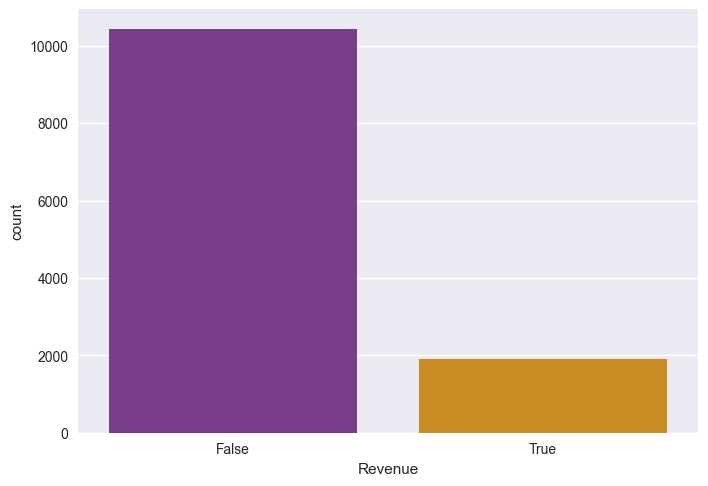

In [6]:
sns.countplot(x='Revenue', data=dummy_data, palette='CMRmap')
class_percent = dummy_data['Revenue'].value_counts(normalize=True) * 100
print('Sessions without purchase : {:.2f}%'.format(class_percent[0]))
print('Sessions with purchase: {:.2f}%'.format(class_percent[1]))

Условимся, что лучшей будет считаться та модель, у которой значение метрики F1 для пользователей, совершивших покупку, будет наибольшим.

По традиции разделим набор данных на матрицу наблюдений X и вектор ответов y:

In [7]:
X, y = dummy_data.drop('Revenue', axis=1), dummy_data['Revenue']

Давайте заранее определимся, как мы будем производить контроль качества наших моделей:

- Разделим выборку на тренировочную и тестовую.
- Будем проводить кросс-валидацию на тренировочной выборке (то есть будем делить её на тренировочные и валидационные фолды и считать среднее значение метрики по фолдам).

Итого мы будем использовать три показателя:

- значение метрики на тренировочных и валидационных фолдах кросс-валидации (по ним мы будем отслеживать переобучение модели и подбирать внешние параметры);
- значение метрики на отложенной тестовой выборке (оно будет нашим контрольным показателем).

Другими словами, мы будем сочетать hold-оut- и k-fold-подходы к валидации.

## Задание 6.2

Для начала позаботимся о создании отложенной тестовой выборки.

Разделите выборку на тренировочную и тестовую в соотношении 80/20. Используйте разбиение, стратифицированное по целевому признаку. В качестве значения параметра random_state возьмите число 42.

Чему равно количество сессий на сайте в тренировочной и тестовой выборках?

In [8]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [13]:
print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_valid.shape))

Train shape: (9864, 28)
Valid shape: (2466, 28)


## Задание 6.3

Коллеги посоветовали нам использовать случайный лес (Random Forest) для решения данной задачи. Давайте последуем их совету.

Создайте модель случайного леса. В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.

Оцените качество такой модели с помощью кросс-валидации по пяти фолдам. Так как классы несбалансированы, используйте кросс-валидатор StratifiedKFold (перемешивать выборку не нужно).

Для проведения кросс-валидации используйте функцию cross_validate(). Набор данных (параметры X, y) — тренировочная выборка (X_train, y_train). Метрика — F1-score.

Чему равно среднее значение метрики F1 на тренировочных и валидационных фолдах? Ответ округлите до двух знаков после точки-разделителя.

In [24]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(
    #n_estimators=500,
    #max_depth=8,    
    #criterion='entropy',
    #min_samples_leaf=10,
    random_state=42
)
#Обучаем модель
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [26]:
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Вычисляем координаты для построения кривой обучения
cv_metrics = model_selection.cross_validate(
    estimator = rf, #модель
    X = X_train, #матрица наблюдений X
    y = y_train, #вектор ответов y
    cv = skf, #кросс-валидатор
    scoring = 'f1', #метрика
    return_train_score=True
)

print (cv_metrics['train_score'].mean())
print (round(cv_metrics['test_score'].mean(),2))



0.9999180663662433
0.65


In [23]:
model = ensemble.RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

skf = model_selection.StratifiedKFold(n_splits=5)

cv_metrics = model_selection.cross_validate(
    model, X_train, y_train, cv=skf, scoring='f1', return_train_score=True
) 

print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score']))) 
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score']))) 

Train k-fold mean f1: 1.00
Valid k-fold mean f1: 0.65


In [16]:
# Для того чтобы вычислить среднюю кросс-валидационную метрику на каждом из наборов данных, необходимо рассчитать среднее по столбцам матриц train_scores и valid_scores:

train_scores_mean = np.mean(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
 
print('Train k-fold f1 scores',  train_scores_mean)
print('Valid k-fold f1 scores',  valid_scores_mean)

Train k-fold f1 scores [0.8        1.         0.99967923 0.99990736 1.        ]
Valid k-fold f1 scores [0.40944309 0.56633584 0.55998076 0.60432132 0.62745366]


## Задание 6.5

Попробуем использовать несколько вариаций случайного леса и с помощью кривых обучения постараемся выбрать наилучшую из них.

Создайте список из трёх следующих моделей:

- Случайный лес из деревьев максимальной глубины 5.
- Случайный лес из деревьев максимальной глубины 7.
- Случайный лес из деревьев максимальной глубины 12.<br>
Для всех трёх моделей количество деревьев в лесу (n_estimators) возьмите равным 200, количество объектов в листе (min_samples_leaf) — 5. Параметр random_state = 42. Остальные параметры оставьте по умолчанию.

Постройте для каждой из моделей кривую обучения.

In [27]:
#Создаём список из моделей
models = [
    ensemble.RandomForestClassifier(
    n_estimators=200,
    max_depth=5,    
    #criterion='entropy',
    min_samples_leaf=5,
    random_state=42),    
    ensemble.RandomForestClassifier(
    n_estimators=200,
    max_depth=7,    
    #criterion='entropy',
    min_samples_leaf=5,
    random_state=42),
    ensemble.RandomForestClassifier(
    n_estimators=200,
    max_depth=12,    
    #criterion='entropy',
    min_samples_leaf=5,
    random_state=42),
]

In [28]:
def plot_learning_curve(model, X, y, cv, scoring="f1", ax=None, title=""):
    # Вычисляем координаты для построения кривой обучения
    train_sizes, train_scores, valid_scores = model_selection.learning_curve(
        estimator=model,  # модель
        X=X,  # матрица наблюдений X
        y=y,  # вектор ответов y
        cv=cv,  # кросс-валидатор
        scoring=scoring,  # метрика
    )
    # Вычисляем среднее значение по фолдам для каждого набора данных
    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    # Если координатной плоскости не было передано, создаём новую
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))  # фигура + координатная плоскость
    # Строим кривую обучения по метрикам на тренировочных фолдах
    ax.plot(train_sizes, train_scores_mean, label="Train")
    # Строим кривую обучения по метрикам на валидационных фолдах
    ax.plot(train_sizes, valid_scores_mean, label="Valid")
    # Даём название графику и подписи осям
    ax.set_title("Learning curve: {}".format(title))
    ax.set_xlabel("Train data size")
    ax.set_ylabel("Score")
    # Устанавливаем отметки по оси абсцисс
    ax.xaxis.set_ticks(train_sizes)
    # Устанавливаем диапазон оси ординат
    ax.set_ylim(0, 1)
    # Отображаем легенду
    ax.legend()

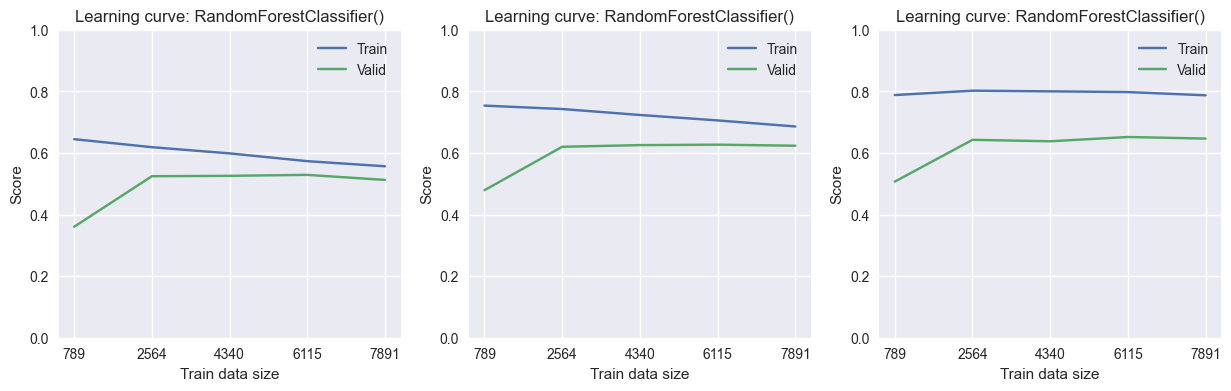

In [30]:
#Создаем объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Визуализируем кривые обучения
fig, axes = plt.subplots(1, 3, figsize=(15, 4)) #фигура + 3 координатных плоскости
#Создаем цикл по списку моделей и индексам этого списка
for i, model in enumerate(models): #i-текущий индекс, model - текущая модель
    plot_learning_curve(
        model, X_train, y_train, 
        skf, 
        ax=axes[i], 
        title=model.__class__.__name__ + '()'
)

## Задание 6.6

Обучите случайный лес с выбранной в предыдущем задании оптимальной глубиной на тренировочной выборке. Сделайте предсказание меток классов и выведите отчёт о метриках классификации.

In [42]:
rf =    ensemble.RandomForestClassifier(
    n_estimators=200,
    max_depth=7,    
    #criterion='entropy',
    min_samples_leaf=5,
    random_state=42)

In [43]:
rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=7, min_samples_leaf=5, n_estimators=200,
                       random_state=42)

In [44]:
#Делаем предсказание для каждой из выборок
y_train_pred = rf.predict(X_train)
y_valid_pred = rf.predict(X_valid)
#Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

       False       0.91      0.98      0.94      2084
        True       0.79      0.49      0.60       382

    accuracy                           0.90      2466
   macro avg       0.85      0.73      0.77      2466
weighted avg       0.89      0.90      0.89      2466



## Задание 6.7

Попробуем повысить качество распознавания посетителей, совершивших покупку. Используем метод подбора порога вероятности с помощью PR-кривой.

Порог вероятности будем подбирать с помощью кросс-валидации.

Сделайте предсказание вероятностей принадлежности к пользователям, которые совершат покупку, на кросс-валидации на пяти фолдах. Используйте метод cross_val_predict().

Для кросс-валидации используйте случайный лес с подобранной в задании 6.5 оптимальной максимальной глубиной деревьев, набор данных (параметры X, y) — тренировочная выборка (X_train, y_train).

Постройте PR-кривую и отметьте на ней точку, в которой наблюдается максимум метрики F1 для посетителей, которые совершат покупку. Определите порог вероятности, соответствующий этой точке.

In [45]:
#Создаём модель
#model = tree.DecisionTreeClassifier(
#    criterion='entropy', #критерий информативности
#    max_depth=7, #максимальная глубина
#    min_samples_leaf=5, #минимальное число объектов в листе
#    random_state=42 #генератор случайных чисел 
#)

#Обучаем модель
#model.fit(X_train, y_train)

model = rf

#Создаём кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Делаем предсказание вероятностей на кросс-валидации
y_cv_proba_pred = model_selection.cross_val_predict(model, X_train, y_train, cv=skf, method='predict_proba')

In [46]:
y_cv_proba_pred

array([[0.67751554, 0.32248446],
       [0.96913055, 0.03086945],
       [0.97981615, 0.02018385],
       ...,
       [0.98993487, 0.01006513],
       [0.47892495, 0.52107505],
       [0.30235619, 0.69764381]])

In [47]:
#Выделяем столбец с вероятностями для класса 1 
y_cv_proba_pred = y_cv_proba_pred[:, 1]

In [48]:
y_cv_proba_pred

array([0.32248446, 0.03086945, 0.02018385, ..., 0.01006513, 0.52107505,
       0.69764381])

In [49]:
#Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)

print('Thresholds:', thresholds[:5])
print('Precision scores:', precision[:5])
print('Recall scores:',recall[:5])

Thresholds: [0.0016146  0.00183509 0.00191163 0.00191452 0.00194508]
Precision scores: [0.15470397 0.15471966 0.15473535 0.15475104 0.15476673]
Recall scores: [1. 1. 1. 1. 1.]


Best threshold = 0.36, F1-Score = 0.69


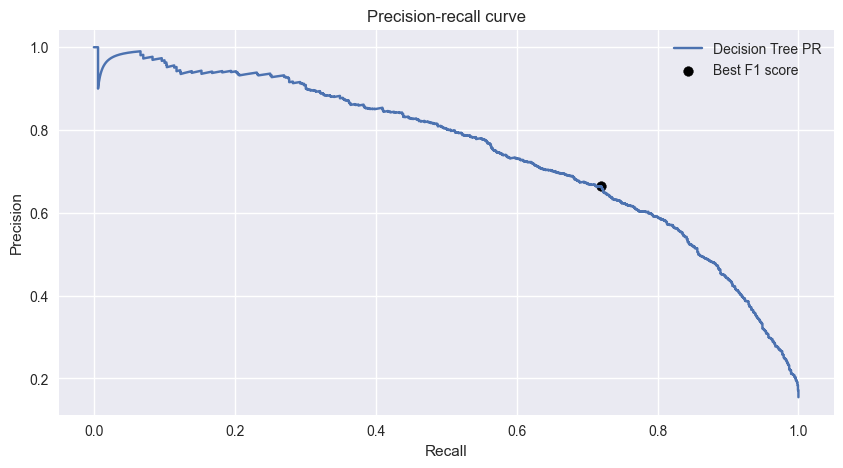

In [50]:
#Вычисляем F1-меру при различных threshold
f1_scores = (2 * precision * recall) / (precision + recall)
#Определяем индекс максимума
idx = np.argmax(f1_scores)
print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(thresholds[idx], f1_scores[idx]))

#Строим PR-кривую
fig, ax = plt.subplots(figsize=(10, 5)) #фигура + координатная плоскость
#Строим линейный график зависимости precision от recall
ax.plot(recall, precision, label='Decision Tree PR')
#Отмечаем точку максимума F1
ax.scatter(recall[idx], precision[idx], marker='o', color='black', label='Best F1 score')
#Даем графику название и подписи осям
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
#Отображаем легенду
ax.legend();

## Задание 6.8

Сделайте предсказание классов объекта с определённым в предыдущем задании порогом вероятности. Выведите отчёт о метриках классификации.

In [51]:
#Задаём оптимальный порог вероятностей
threshold_opt = 0.36
#Образцы воды, для которых вероятность быть пригодными для питья > threshold_opt, относим к классу 1
#В противном случае — к классу 0
y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]
y_valid_pred = (y_valid_pred_proba > threshold_opt).astype('int')
#Считаем метрики
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

       False       0.94      0.93      0.94      2084
        True       0.66      0.69      0.67       382

    accuracy                           0.90      2466
   macro avg       0.80      0.81      0.81      2466
weighted avg       0.90      0.90      0.90      2466

